In [235]:
'''
В данном ноутбуке постарался сохранить больше данных, а также применить новые методы обработки пустых значений + применил нелинейные модели
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_excel("data.xlsx")

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112635 entries, 0 to 112634
Data columns (total 56 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ссылка                112635 non-null  object 
 1   до центра             106897 non-null  object 
 2   комнат                112635 non-null  object 
 3   Площадь квартиры      112583 non-null  object 
 4   Жилая площадь         90732 non-null   object 
 5   Этаж                  111822 non-null  float64
 6   Санузел               71990 non-null   object 
 7   Кол-во санузлов       90622 non-null   float64
 8   Ремонт                48258 non-null   object 
 9   Вид из окна           61723 non-null   object 
 10  Год постройки         20837 non-null   float64
 11  Высота потолков       83705 non-null   object 
 12  Лифт                  85074 non-null   object 
 13  Материал стен         95838 non-null   object 
 14  Парковка              60672 non-null   object 
 15  

In [237]:
# Удаляем столбцы, которые являются служебными или имеют очень низкое покрытие данных,
# и, следовательно, не влияют на предсказание стоимости квартиры.
#адрес и описание тяжело на данный момент обработать так, чтобы вытащить оттуда полезную информацию - уберем их из датасета
columns_to_drop = [
    'ссылка',
    'Source_File',
    'Sheet_Name',
    'Кондиционер',
    'Мебель',
    'Кухонная мебель',
    'Реновация',
    'Посудомойка',
    'Интернет',
    'Телевизор',
    'Холодильник',
    'Стиральная машина',
    'Консьерж',
    'адрес',
    'описание',
    
]

df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112635 entries, 0 to 112634
Data columns (total 41 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   до центра             106897 non-null  object 
 1   комнат                112635 non-null  object 
 2   Площадь квартиры      112583 non-null  object 
 3   Жилая площадь         90732 non-null   object 
 4   Этаж                  111822 non-null  float64
 5   Санузел               71990 non-null   object 
 6   Кол-во санузлов       90622 non-null   float64
 7   Ремонт                48258 non-null   object 
 8   Вид из окна           61723 non-null   object 
 9   Год постройки         20837 non-null   float64
 10  Высота потолков       83705 non-null   object 
 11  Лифт                  85074 non-null   object 
 12  Материал стен         95838 non-null   object 
 13  Парковка              60672 non-null   object 
 14  цена                  112635 non-null  object 
 15  

In [238]:
#удалим дубликаты
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88322 entries, 0 to 112634
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   до центра             83909 non-null  object 
 1   комнат                88322 non-null  object 
 2   Площадь квартиры      88306 non-null  object 
 3   Жилая площадь         70860 non-null  object 
 4   Этаж                  87933 non-null  float64
 5   Санузел               56621 non-null  object 
 6   Кол-во санузлов       70782 non-null  float64
 7   Ремонт                38459 non-null  object 
 8   Вид из окна           48004 non-null  object 
 9   Год постройки         17043 non-null  float64
 10  Высота потолков       65234 non-null  object 
 11  Лифт                  67019 non-null  object 
 12  Материал стен         75226 non-null  object 
 13  Парковка              47867 non-null  object 
 14  цена                  88322 non-null  object 
 15  станция1              8

In [239]:
df['Серия дома'].unique()

array([nan, '1-511', 'II-49', 'II-18', '1-515', '1605-АМ', 'П-3',
       '1-МГ-601', 'П-44Т', 'II-68', 'П-30', 'П-44', 'II-29', 'П-3М',
       '1-510', 'II-05', 'П-46м', 'Башня Вулыха', 'П-44К', 'II-57',
       'И-209А', 'П-46', 'П-111М', 'П-43', '137', '1-335', 'И-155',
       'И-700', 'ПД-4', 'II-18/12', 'И-522', 'П-47', 'К-7', 'КОПЭ',
       'И-491А', 'C-222', 'П-23', 'П-55', 'ГМС-2001', 'П-44/17',
       'КОПЭ-2000', 'II-67', 'П-55М', 'II-66', 'ИП-46С',
       'Башня Смирновская', 'П-42', 'Башня Москворецкая'], dtype=object)

In [240]:
#переводим в числовой формат все столбцы, которые можно перевести из object
def convert_to_numeric(df, threshold=0.7):
    """
    Преобразует столбцы DataFrame в числовой тип, если доля преобразованных значений среди непустых
    значений в столбце превышает порог threshold.
    """
    for col in df.columns:
        # Если столбец имеет тип object, то применяем замену запятых на точки
        if df[col].dtype == 'object':
            # Приводим к строке, затем заменяем запятые на точки
            converted_col = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
        else:
            converted_col = pd.to_numeric(df[col], errors='coerce')
        # Число ненулевых (не NaN) исходных значений
        non_missing = df[col].notna().sum()
        if non_missing == 0:
            # Если столбец полностью пустой, ничего не делаем
            continue
        # Доля успешно преобразованных значений (без учета исходных пропущенных значений)
        ratio = converted_col.notna().sum() / non_missing
        # if col=='Площадь кухни' or col=='Высота потолков' or col=='Жилая площадь' or col=='Площадь квартиры' or col=='до центра':
        #     print(ratio)
        #     print(df[col].unique())
        if ratio >= threshold: # Если доля преобразованных значений больше порога, заменяем столбец
            df[col] = converted_col

    return df

df_cleaned = convert_to_numeric(df_cleaned)
print(df_cleaned.dtypes)

до центра               float64
комнат                  float64
Площадь квартиры        float64
Жилая площадь           float64
Этаж                    float64
Санузел                  object
Кол-во санузлов         float64
Ремонт                   object
Вид из окна              object
Год постройки           float64
Высота потолков         float64
Лифт                     object
Материал стен            object
Парковка                 object
цена                    float64
станция1                 object
время_до_станции1       float64
пешком1                 float64
станция2                 object
время_до_станции2       float64
пешком2                 float64
станция3                 object
время_до_станции3       float64
пешком3                 float64
Этажей в доме           float64
Отделка                  object
Срок сдачи               object
Временная эпоха          object
Отопление                object
Тип жилья                object
Балкон/лоджия            object
Серия до

In [241]:
df_cleaned.describe(include='number')

,до центра,комнат,Площадь квартиры,Жилая площадь,Этаж,Кол-во санузлов,Год постройки,Высота потолков,цена,время_до_станции1,пешком1,время_до_станции2,пешком2,время_до_станции3,пешком3,Этажей в доме,Площадь кухни
count,83909.000000,82921.000000,88294.000000,70859.000000,87933.000000,70782.000000,17043.000000,65234.000000,8.831900e+04,88083.000000,88083.000000,87994.000000,87994.000000,87965.000000,87965.000000,87933.000000,68459.000000
mean,12.557311,1.864606,65.206774,33.772472,11.020106,1.321084,2020.054274,3.198968,3.792226e+07,18.478367,0.843352,24.610155,0.695377,27.698642,0.515341,20.296567,13.256700
std,7.185627,1.067980,53.161379,30.740168,9.396640,0.657399,4.847497,8.504692,1.046647e+08,12.355225,0.363470,12.164711,0.460250,12.022789,0.499767,13.120658,8.058355
min,0.000000,0.000000,8.000000,1.000000,-1.000000,1.000000,1885.000000,-15.000000,1.180000e+04,1.000000,0.000000,2.000000,0.000000,3.000000,0.000000,1.000000,0.500000
25%,7.200000,1.000000,37.900000,18.000000,4.000000,1.000000,2018.000000,2.700000,1.176204e+07,10.000000,1.000000,16.000000,0.000000,21.000000,0.000000,12.000000,8.000000
50%,12.000000,2.000000,53.100000,27.500000,9.000000,1.000000,2021.000000,2.850000,1.700000e+07,15.000000,1.000000,23.000000,1.000000,26.000000,1.000000,17.000000,10.900000
75%,16.400000,3.000000,73.500000,40.600000,15.000000,2.000000,2023.000000,3.020000,2.926006e+07,23.000000,1.000000,28.000000,1.000000,30.000000,1.000000,25.000000,16.900000
max,30.000000,4.000000,993.600000,832.000000,94.000000,12.000000,2026.000000,390.000000,1.099373e+10,90.000000,1.000000,90.000000,1.000000,90.000000,1.000000,97.000000,140.000000


In [242]:
#видим аномалии в в следующих столбцах (оставим при фильтрации NaN значения)
'''Площадь квартиры - максимум 993 кв.м - уберем все квартиры с площадью больше 200 кв.м 
- так как сегмент квартир с площадью больше 230 кв.м. вряд ли будет интересен для анализа'''
df_cleaned = df_cleaned[(df_cleaned['Площадь квартиры'] <= 300) | (df_cleaned['Площадь квартиры'].isna())]

#Жилая площадь - возьмем максимум 270 кв.м
df_cleaned = df_cleaned[(df_cleaned['Жилая площадь'] <= 270) | (df_cleaned['Жилая площадь'].isna())]

# Этаж - уберем небоскребы
df_cleaned = df_cleaned[(df_cleaned['Этаж'] <= 35) | (df_cleaned['Этажей в доме'] <= 35) | (df_cleaned['Этаж'].isna())]

# Кол-во санузлов - уберем квартиры с кол-вом санузлов больше 2
df_cleaned = df_cleaned[(df_cleaned['Кол-во санузлов'] <= 2) | (df_cleaned['Кол-во санузлов'].isna())]

# Уберем квартиры, построенные более 100 лет назад
df_cleaned = df_cleaned[(df_cleaned['Год постройки'] >= (pd.Timestamp.now().year - 100)) | (df_cleaned['Год постройки'].isna())]

#Уберем потолки выше 5 метров
df_cleaned = df_cleaned[(df_cleaned['Высота потолков'] <= 5) | (df_cleaned['Высота потолков'].isna())]

# отфильтруем пустую цену и квартиры дороже 100 млн, тк сегмент люкс не рассматриваем
df_cleaned = df_cleaned[(df_cleaned['цена'] <= 100000000) | (df_cleaned['цена'].isna())]

In [243]:
df_cleaned.describe(include='number')
#как видим, большую часть датасета сохранили

,до центра,комнат,Площадь квартиры,Жилая площадь,Этаж,Кол-во санузлов,Год постройки,Высота потолков,цена,время_до_станции1,пешком1,время_до_станции2,пешком2,время_до_станции3,пешком3,Этажей в доме,Площадь кухни
count,75003.000000,76097.000000,79378.000000,64896.000000,79007.000000,63661.000000,14160.00000,59036.000000,7.939100e+04,79160.000000,79160.000000,79072.000000,79072.000000,79043.000000,79043.000000,79007.000000,62080.000000
mean,13.317602,1.775287,54.655342,29.296482,10.179364,1.192363,2020.28863,2.874781,2.108524e+07,19.119315,0.829080,25.432315,0.674866,28.438356,0.485419,19.573405,12.200095
std,6.997705,1.022144,25.502151,17.142424,7.550286,0.394160,4.14097,0.257306,1.566627e+07,12.650834,0.376441,12.268037,0.468428,12.155702,0.499791,11.491270,6.253655
min,0.000000,0.000000,8.000000,1.000000,-1.000000,1.000000,1941.00000,1.550000,1.180000e+04,1.000000,0.000000,2.000000,0.000000,3.000000,0.000000,1.000000,0.500000
25%,8.000000,1.000000,37.000000,17.000000,4.000000,1.000000,2019.00000,2.680000,1.136318e+07,10.000000,1.000000,17.000000,0.000000,21.000000,0.000000,12.000000,8.000000
50%,12.400000,2.000000,50.200000,26.000000,8.000000,1.000000,2021.00000,2.820000,1.584404e+07,16.000000,1.000000,24.000000,1.000000,26.000000,0.000000,17.000000,10.200000
75%,17.700000,2.000000,66.800000,37.600000,14.000000,1.000000,2023.00000,3.000000,2.450000e+07,24.000000,1.000000,29.000000,1.000000,30.000000,1.000000,24.000000,15.900000
max,30.000000,4.000000,300.000000,250.000000,35.000000,2.000000,2026.00000,5.000000,1.000000e+08,90.000000,1.000000,90.000000,1.000000,90.000000,1.000000,89.000000,100.000000


In [244]:
df_cleaned.describe(include='object')

,Санузел,Ремонт,Вид из окна,Лифт,Материал стен,Парковка,станция1,станция2,станция3,Отделка,Срок сдачи,Временная эпоха,Отопление,Тип жилья,Балкон/лоджия,Серия дома,Территория,Вид из окон,Хорошая школа,Парк или зона отдыха,Фитнес клуб,Детский сад,Торговый центр,Хорошие школы
count,52521,33501,44752,60778,67898,42212,79160,79072,79043,24130,34819,12736,23593,6743,26545,16562,10433,7274,2005,2244,1534,2777,2220,2158
unique,2,6,2,1,6,3,285,289,289,3,25,3,2,1,1,47,1,1,5,3,1,4,2,4
top,совмещённый,Хороший,во двор,есть,монолит,закрытая,Ольховая,Коммунарка,Прокшино,без отделки,2026 г.,брежневка,центральное,апартаменты,есть,II-49,закрытая,во двор и на улицу,Детский сад,Торговый центр,Спортивная площадка,Парк или зона отдыха,Фитнес клуб,Детский сад
freq,35039,9670,27528,60778,37929,27568,3496,2518,3367,17059,4117,7817,23233,6743,26545,1994,10433,7274,1205,2032,1534,2521,2146,1199


In [245]:
#последние 6 категорий показывают странные значения - потом преобразуем их

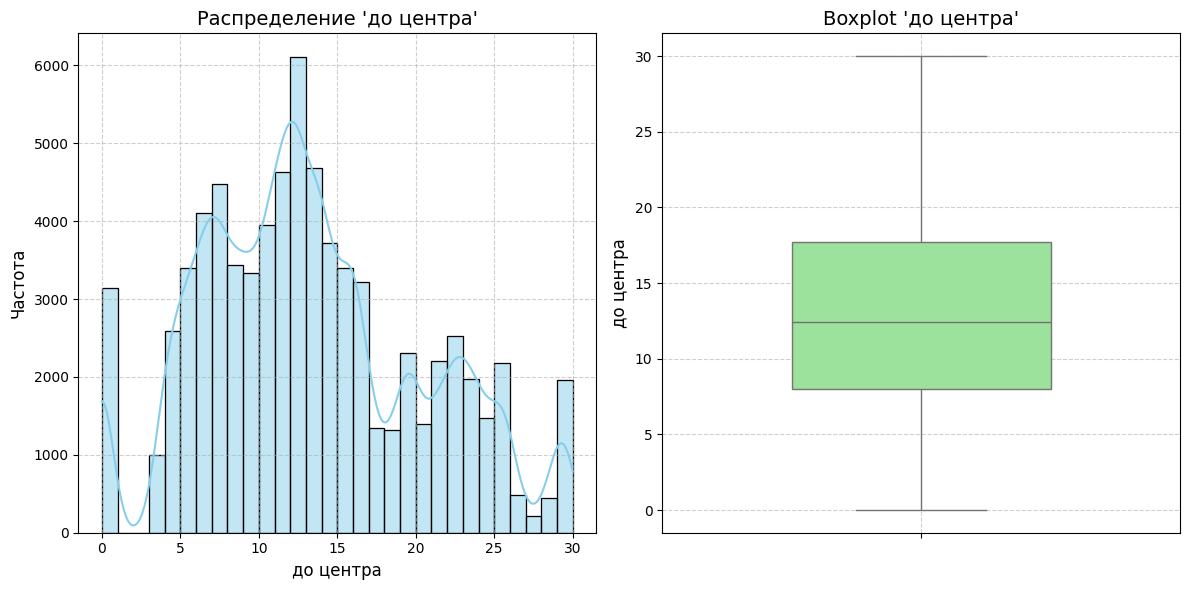

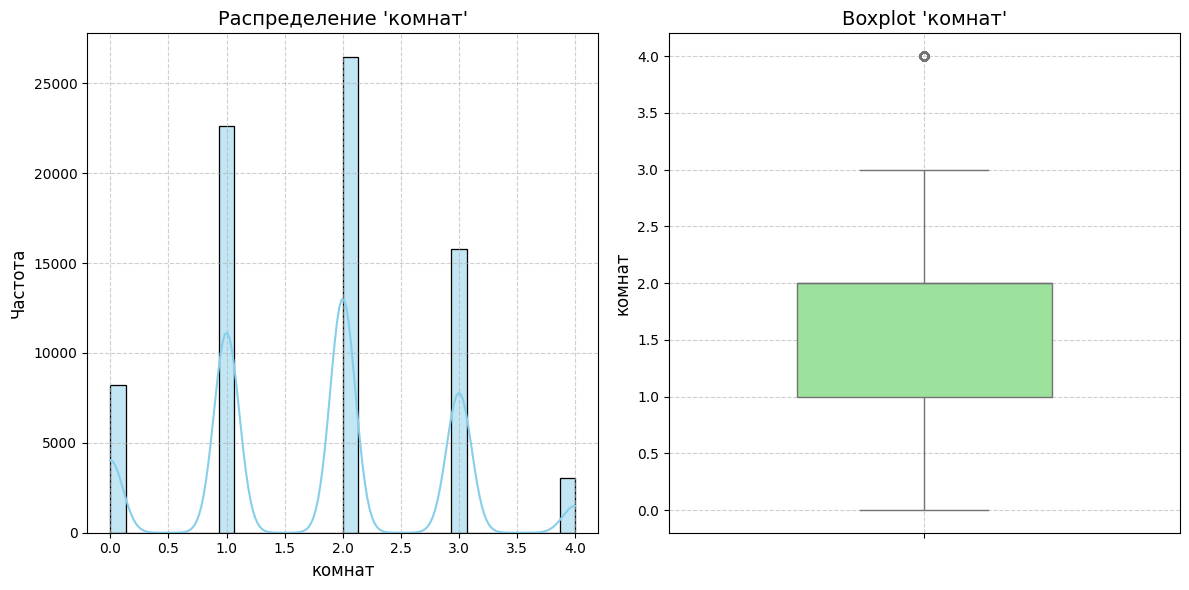

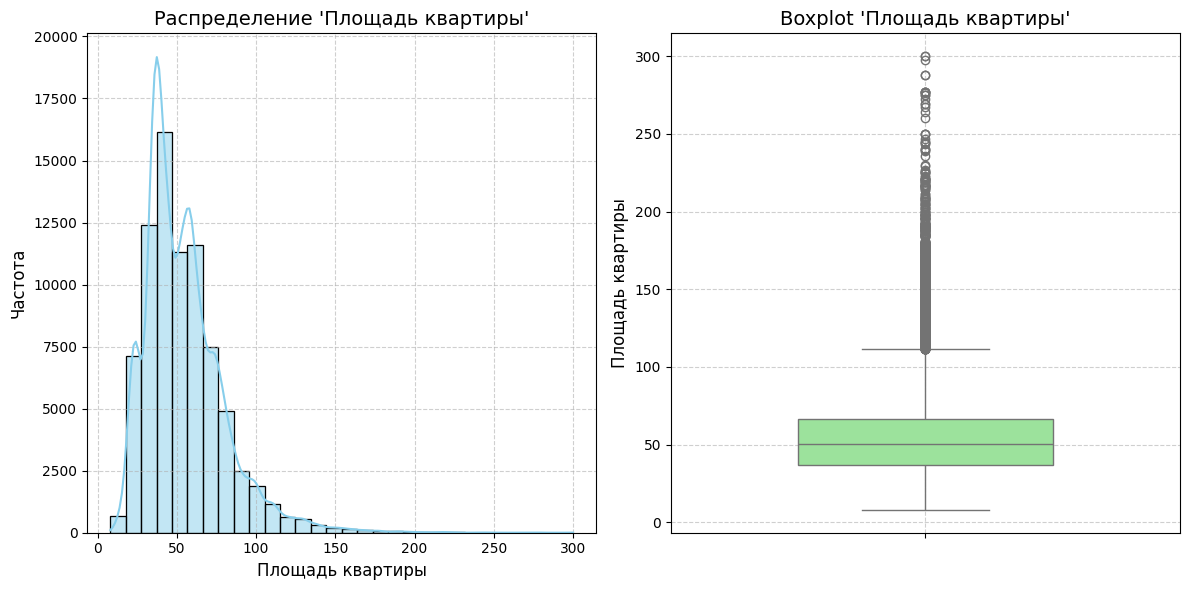

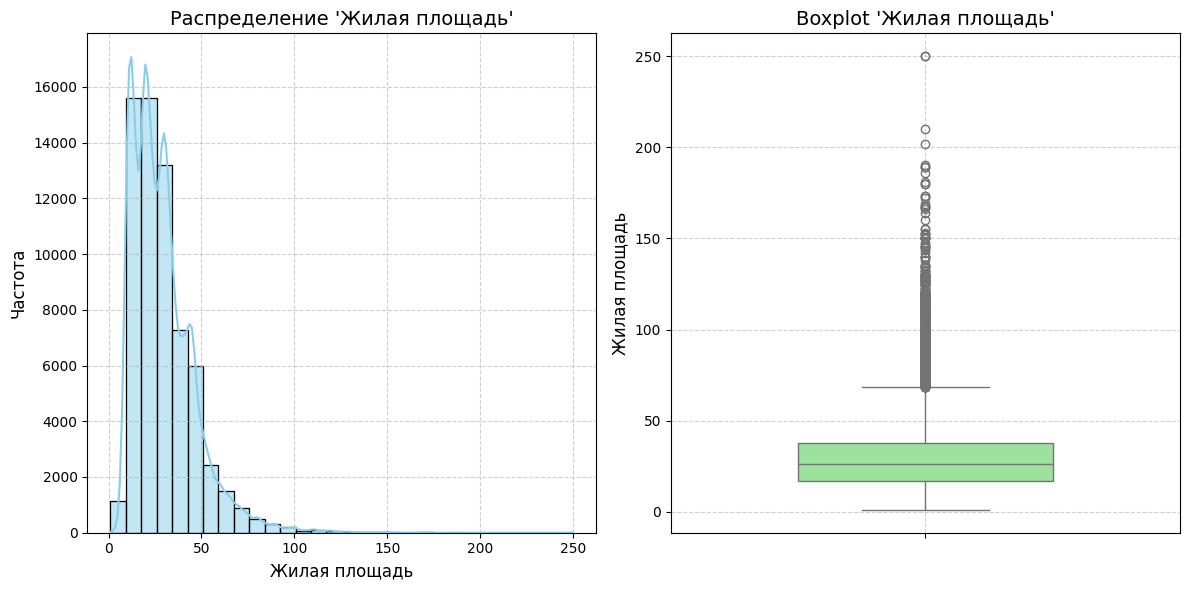

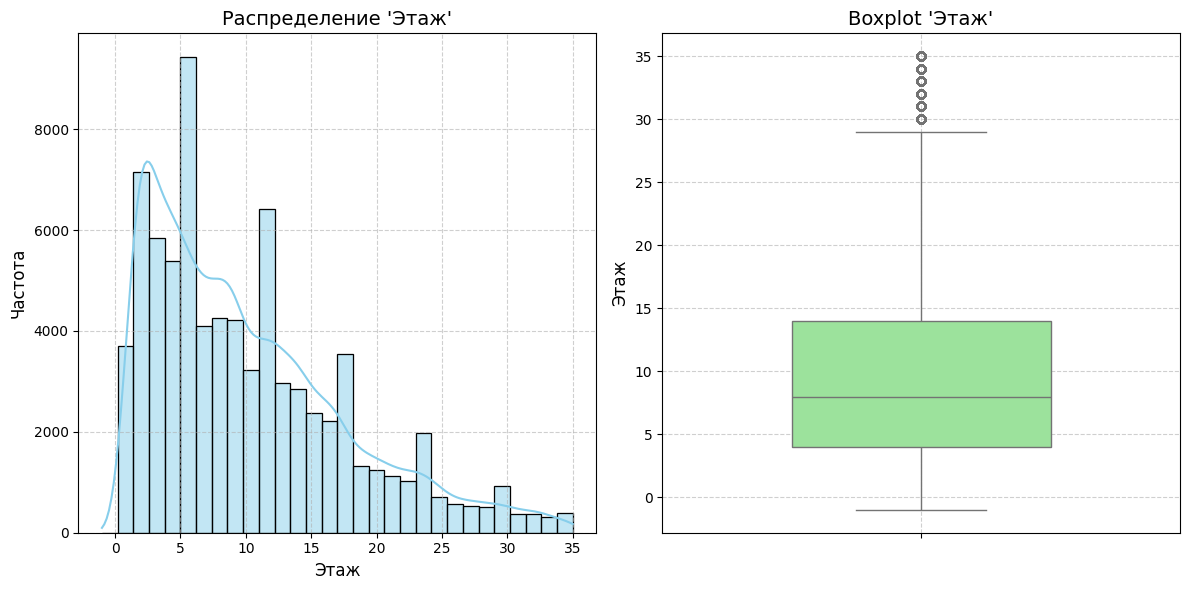

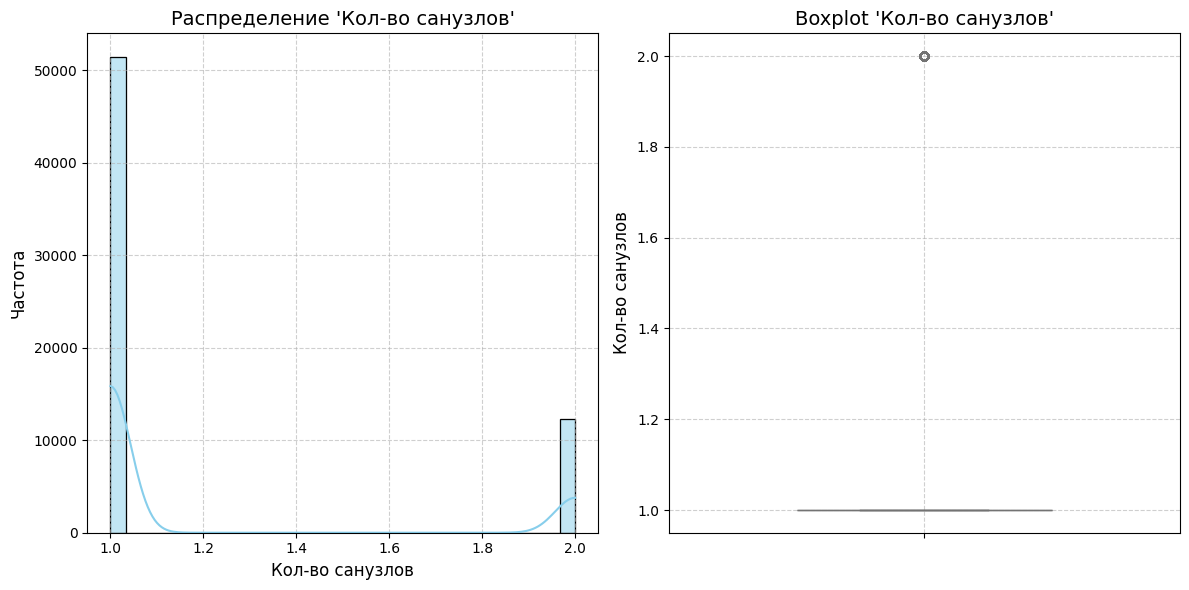

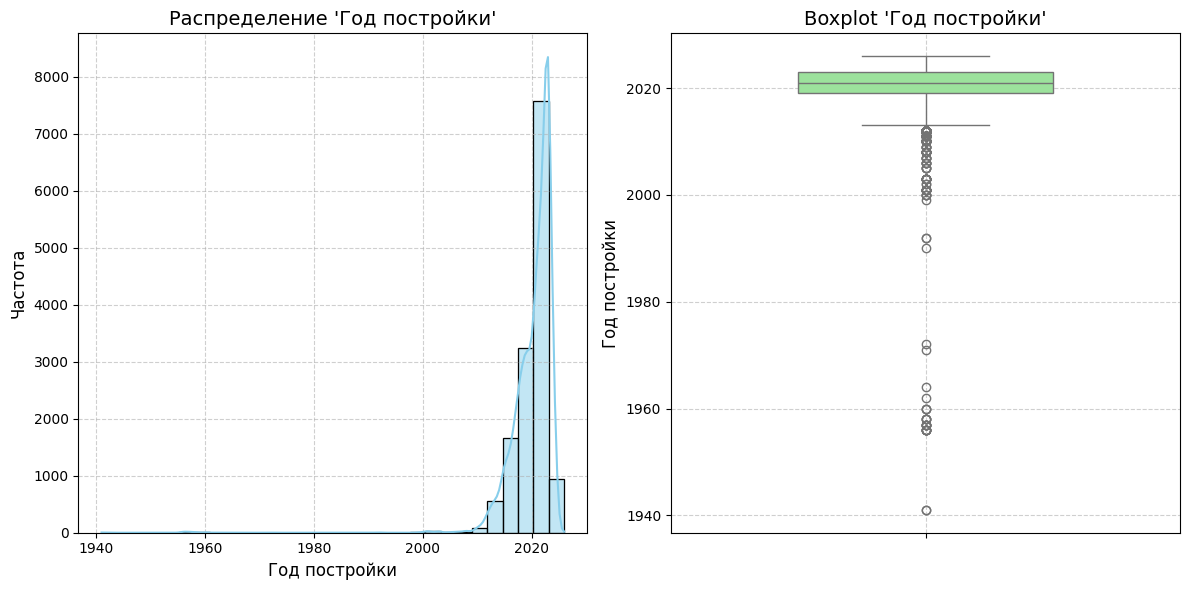

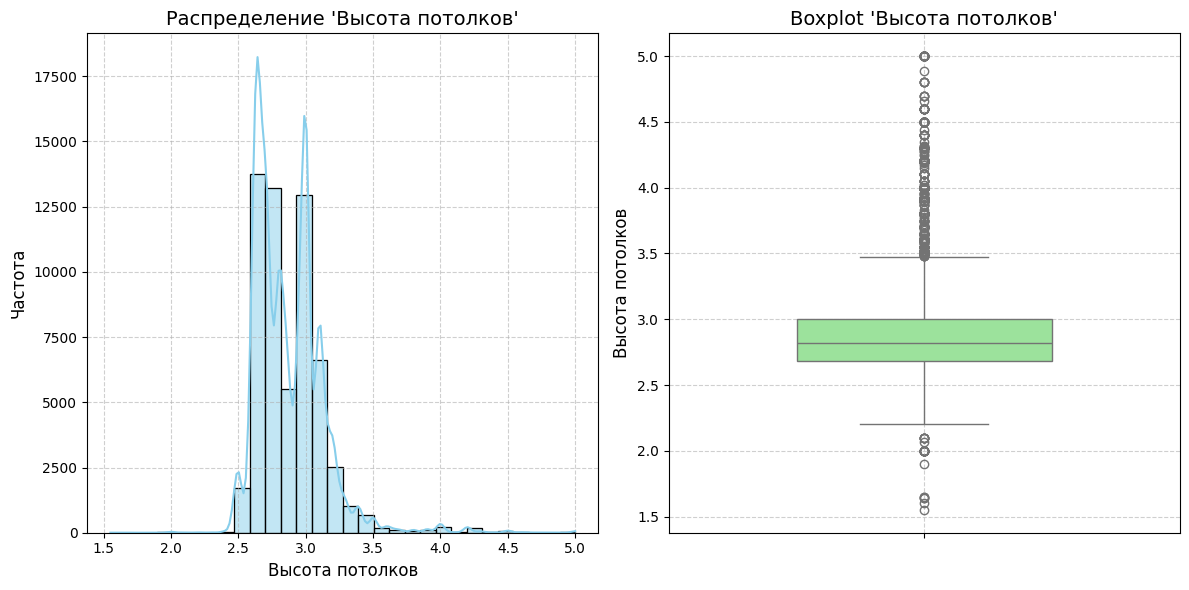

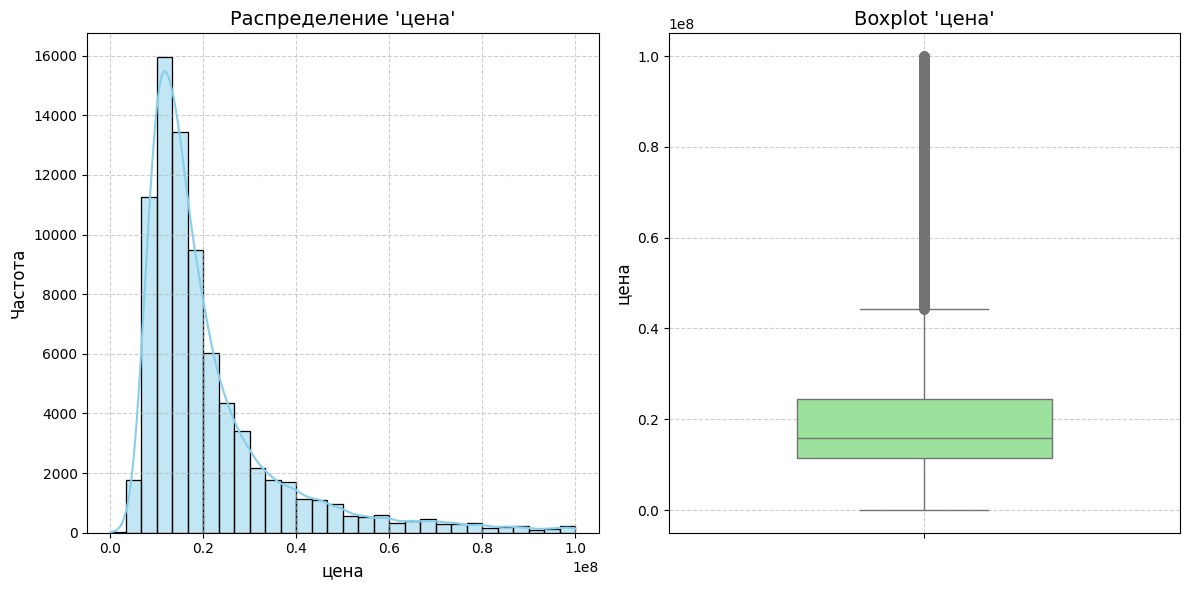

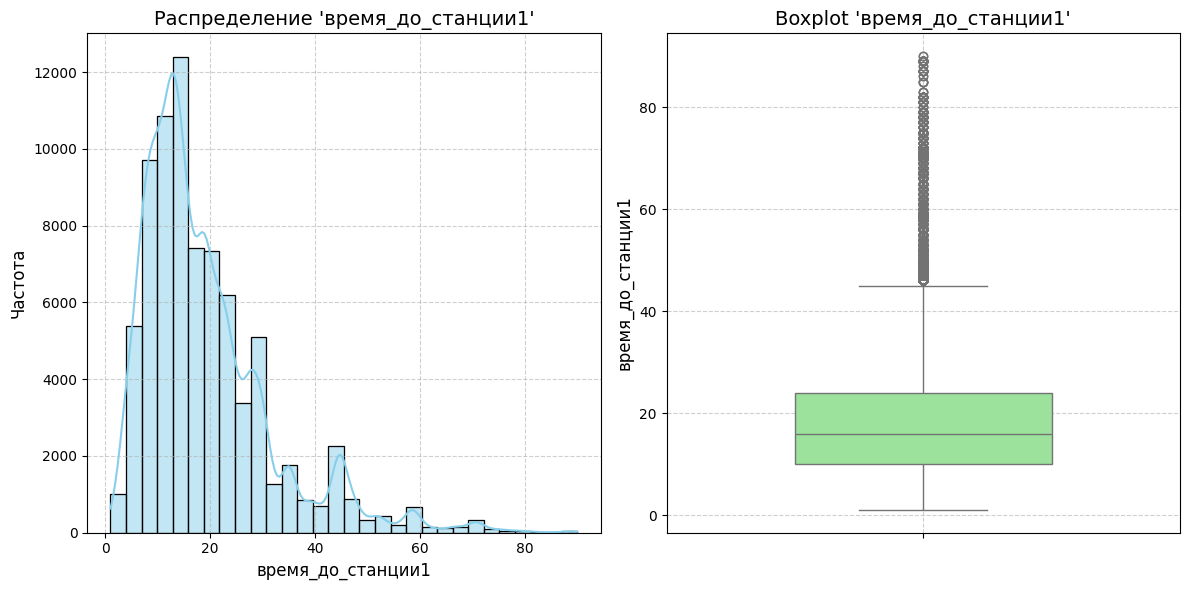

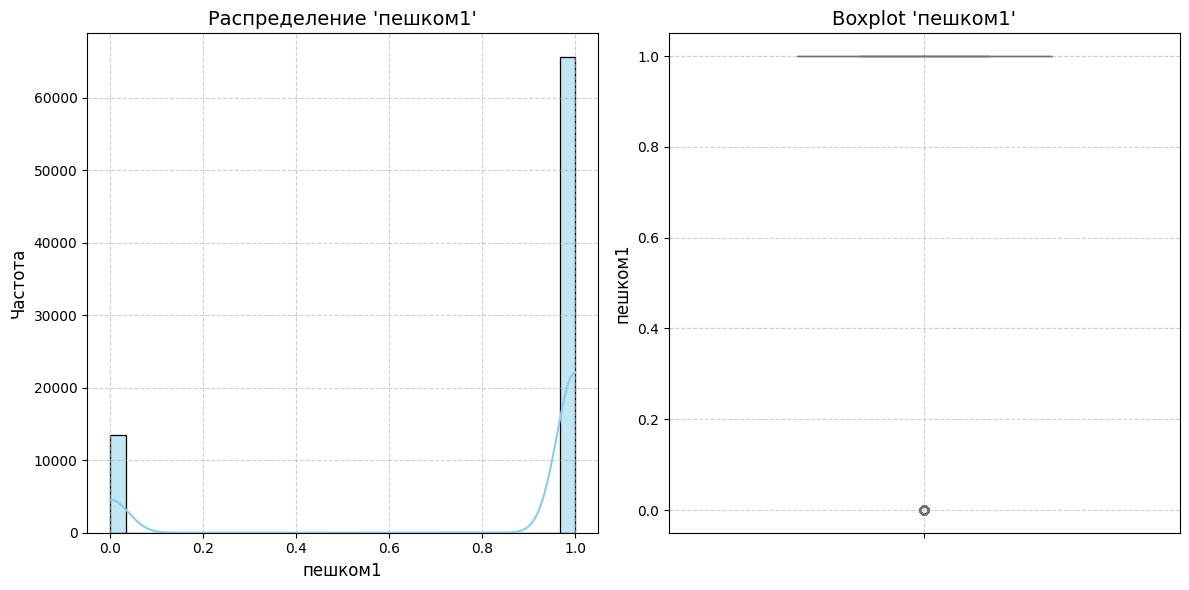

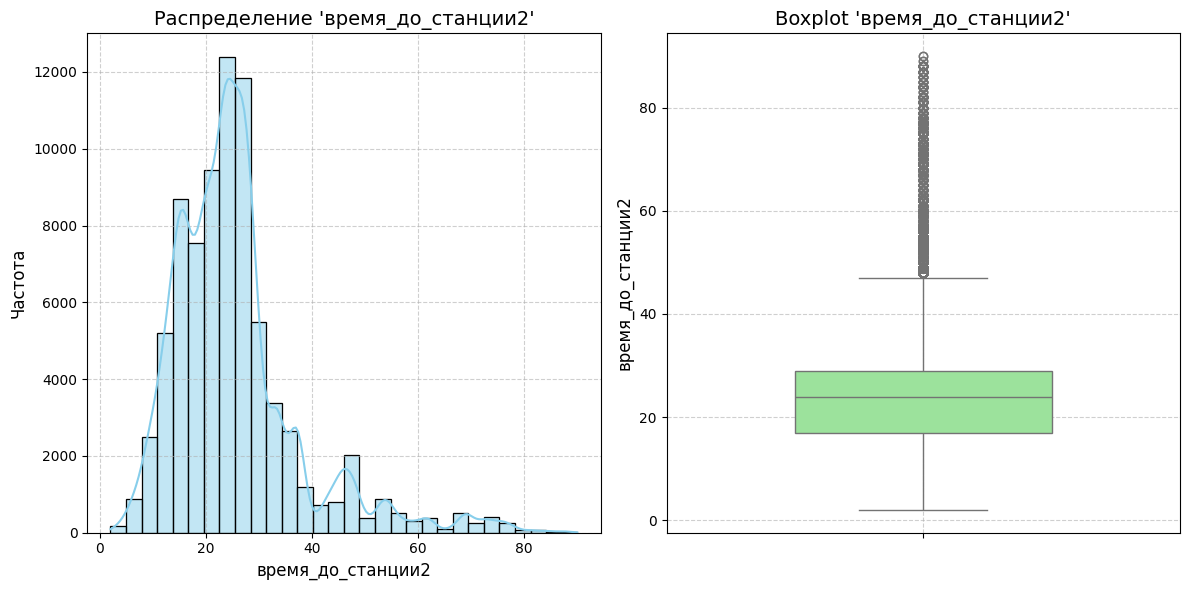

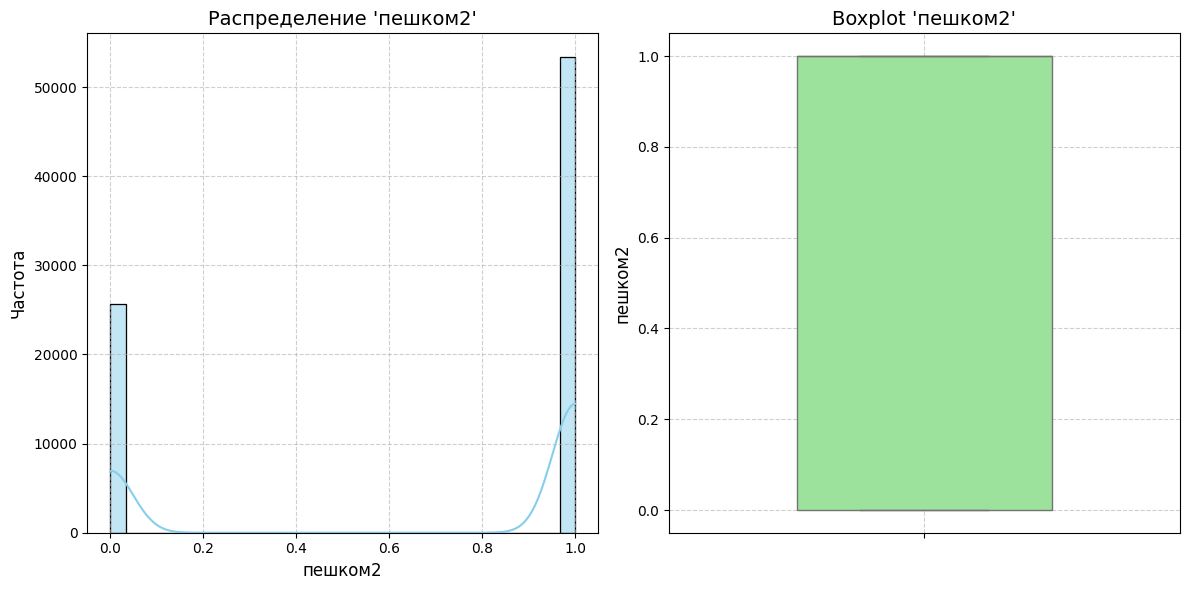

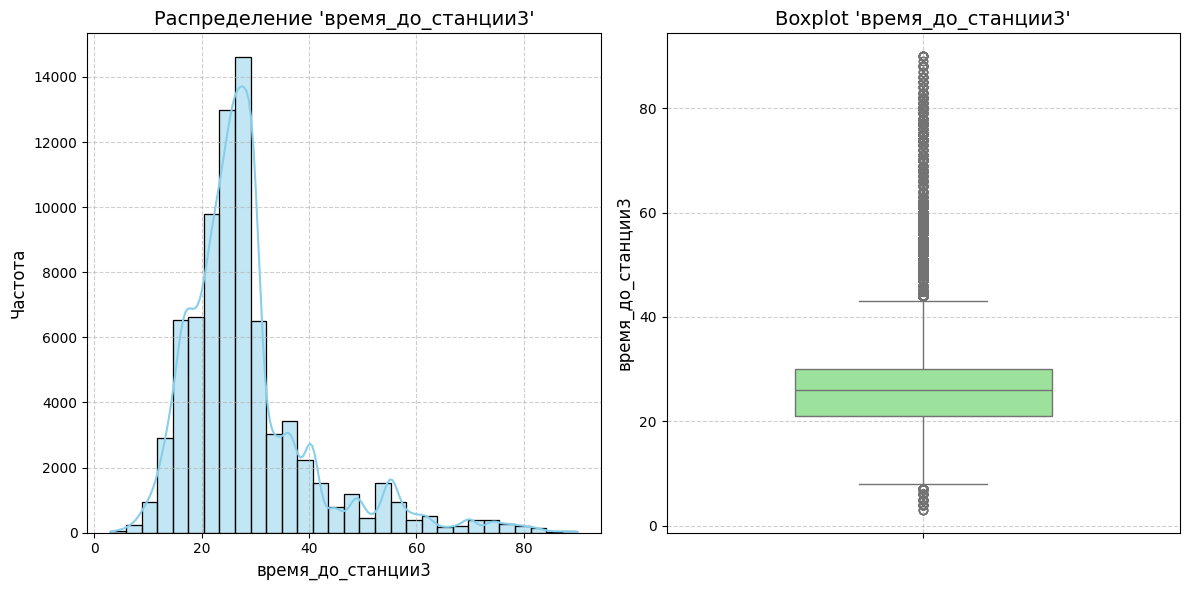

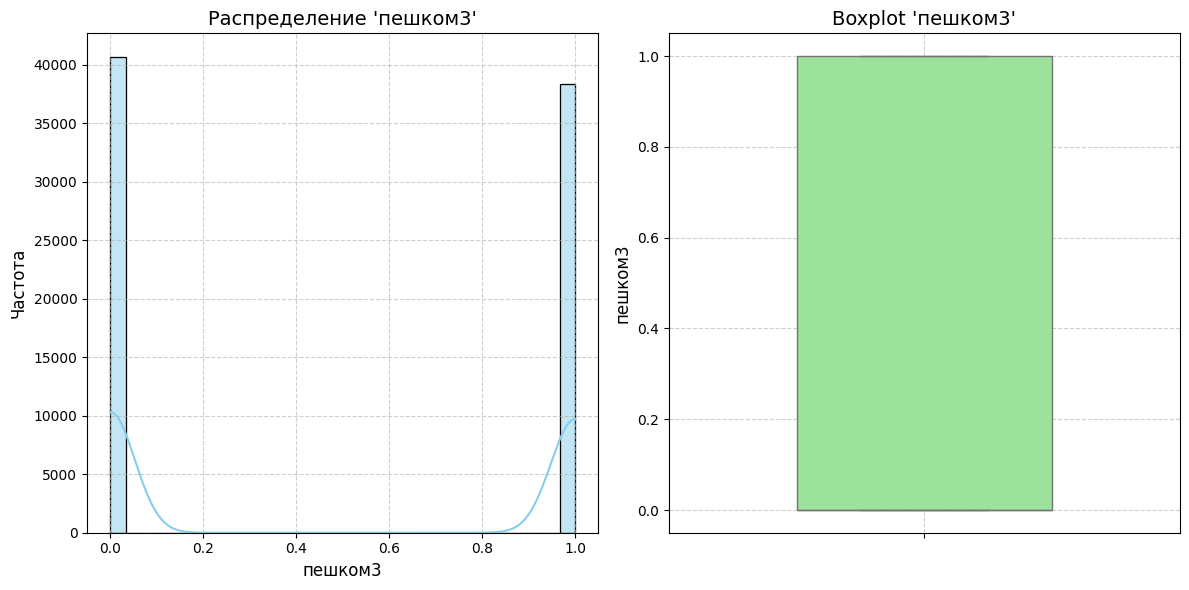

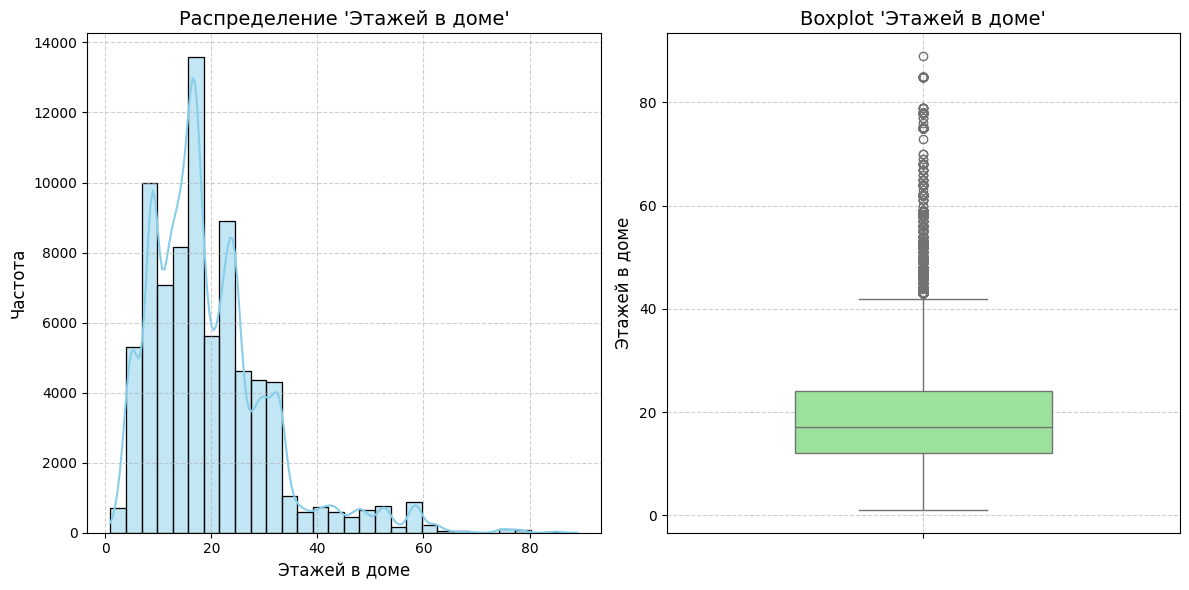

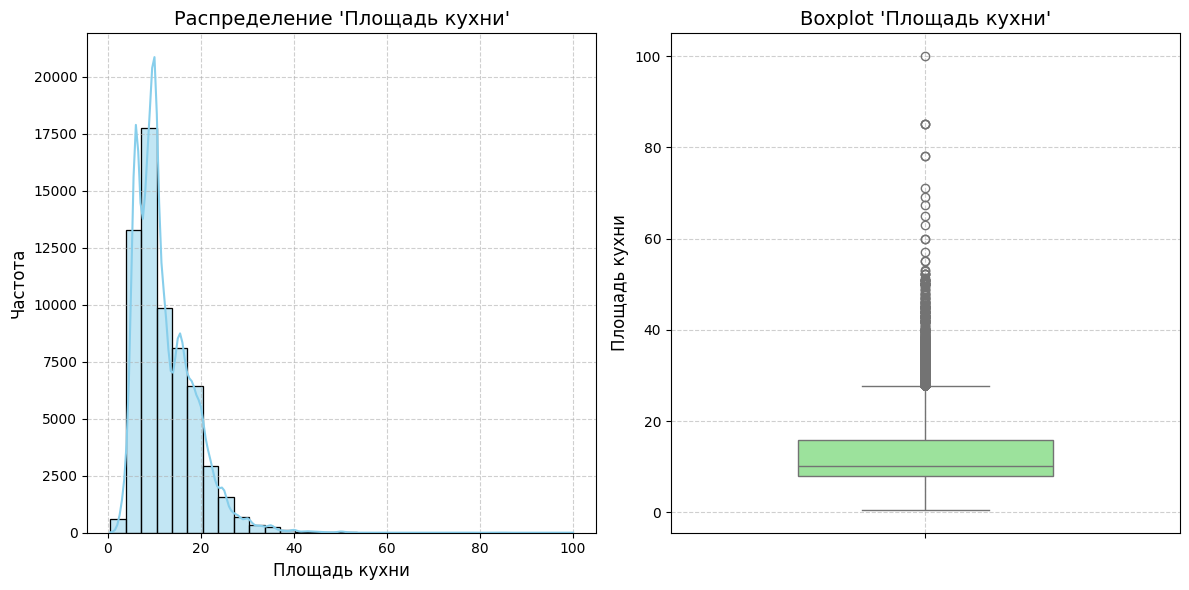

In [246]:
def plot_feature_distributions(data, features):
    for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        sns.histplot(data[feature], bins=30, kde=True, ax=axes[0], color='skyblue', edgecolor='black')
        axes[0].set_title(f"Распределение '{feature}'", fontsize=14)
        axes[0].set_xlabel(feature, fontsize=12)
        axes[0].set_ylabel('Частота', fontsize=12)
        axes[0].grid(visible=True, linestyle='--', alpha=0.6)

        sns.boxplot(y=data[feature], ax=axes[1], color='lightgreen', width=0.5)
        axes[1].set_title(f"Boxplot '{feature}'", fontsize=14)
        axes[1].set_ylabel(feature, fontsize=12)
        axes[1].grid(visible=True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

numerical_features = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
plot_feature_distributions(df_cleaned, numerical_features)

In [247]:
correlation_matrix = df_cleaned.corr(numeric_only=True)
correlation_matrix

,до центра,комнат,Площадь квартиры,Жилая площадь,Этаж,Кол-во санузлов,Год постройки,Высота потолков,цена,время_до_станции1,пешком1,время_до_станции2,пешком2,время_до_станции3,пешком3,Этажей в доме,Площадь кухни
до центра,1.000000,-0.099146,-0.174628,-0.195293,0.015536,-0.107127,-0.090598,-0.252172,-0.475262,0.556190,-0.512516,0.630814,-0.582050,0.599649,-0.578916,-0.060102,-0.096491
комнат,-0.099146,1.000000,0.824615,0.813994,-0.043027,0.399385,-0.051773,0.110855,0.507659,-0.100937,0.075914,-0.105947,0.086858,-0.093101,0.087965,-0.048301,0.123139
Площадь квартиры,-0.174628,0.824615,1.000000,0.892663,0.010385,0.522862,-0.134801,0.272945,0.737699,-0.129311,0.104196,-0.140277,0.137632,-0.125141,0.136540,0.040356,0.409672
Жилая площадь,-0.195293,0.813994,0.892663,1.000000,-0.085846,0.363304,-0.142282,0.230416,0.639683,-0.160865,0.112177,-0.164447,0.136987,-0.149300,0.149064,-0.082119,0.044413
Этаж,0.015536,-0.043027,0.010385,-0.085846,1.000000,0.119707,0.062264,0.007667,0.083900,-0.035708,0.078380,-0.031799,0.028133,-0.027368,-0.000233,0.598037,0.214559
Кол-во санузлов,-0.107127,0.399385,0.522862,0.363304,0.119707,1.000000,0.028756,0.181518,0.465243,-0.030720,0.055697,-0.035660,0.061445,-0.033112,0.035176,0.173087,0.419167
Год постройки,-0.090598,-0.051773,-0.134801,-0.142282,0.062264,0.028756,1.000000,0.026399,-0.080486,0.054770,0.010051,0.065385,0.070128,0.068323,0.043001,0.078444,0.040854
Высота потолков,-0.252172,0.110855,0.272945,0.230416,0.007667,0.181518,0.026399,1.000000,0.473411,-0.090995,0.062861,-0.117645,0.086110,-0.095127,0.145192,0.071859,0.218645
цена,-0.475262,0.507659,0.737699,0.639683,0.083900,0.465243,-0.080486,0.473411,1.000000,-0.292726,0.255182,-0.325594,0.303032,-0.298736,0.305014,0.148920,0.419998
время_до_станции1,0.556190,-0.100937,-0.129311,-0.160865,-0.035708,-0.030720,0.054770,-0.090995,-0.292726,1.000000,-0.766547,0.909852,-0.672411,0.911158,-0.517576,-0.101801,0.009449


In [248]:
#Как и в изначальном EDA уберем колонки из-за сильной зависимости между ними
df_cleaned = df_cleaned.drop(['Жилая площадь', 'Этажей в доме', 'пешком1','пешком2','пешком3'], axis=1)

In [249]:
# Найти примеры заполненных столбцов
filled_columns_examples = {}
for column in df_cleaned.columns:
    filled_example = df_cleaned[column].dropna().iloc[0] if not df_cleaned[column].dropna().empty else None
    filled_columns_examples[column] = filled_example

In [250]:
filled_columns_examples
#посмотрим как выглядит пример каждого заполненного столбца

{'до центра': 7.9,
 'комнат': 0.0,
 'Площадь квартиры': 23.0,
 'Этаж': 20.0,
 'Санузел': 'совмещённый',
 'Кол-во санузлов': 1.0,
 'Ремонт': 'Нужен ремонт',
 'Вид из окна': 'во двор',
 'Год постройки': 2024.0,
 'Высота потолков': 3.0,
 'Лифт': 'есть',
 'Материал стен': 'монолит',
 'Парковка': 'подземная',
 'цена': 11000000.0,
 'станция1': 'Нагатинская',
 'время_до_станции1': 19.0,
 'станция2': 'Коломенская',
 'время_до_станции2': 24.0,
 'станция3': 'Верхние Котлы',
 'время_до_станции3': 28.0,
 'Отделка': 'без отделки',
 'Срок сдачи': '4\xa0кв.\xa02025\xa0г.',
 'Временная эпоха': 'сталинка',
 'Отопление': 'центральное',
 'Тип жилья': 'апартаменты',
 'Балкон/лоджия': 'есть',
 'Серия дома': '1-511',
 'Территория': 'закрытая',
 'Вид из окон': 'во двор и на улицу',
 'Хорошая школа': 'Спортивная площадка',
 'Парк или зона отдыха': 'Торговый центр',
 'Фитнес клуб': 'Спортивная площадка',
 'Детский сад': 'Торговый центр',
 'Торговый центр': 'Фитнес клуб',
 'Хорошие школы': 'Спортивная площадка'

In [251]:
#зафиксируем категориальные признаки, в которых много уникальных значений
cat_cols = df_cleaned.select_dtypes(include=['object']).columns

for col in cat_cols:
    unique_values = df_cleaned[col].nunique()
    print(f"{col}: {unique_values} уникальных значений")

Санузел: 2 уникальных значений
Ремонт: 6 уникальных значений
Вид из окна: 2 уникальных значений
Лифт: 1 уникальных значений
Материал стен: 6 уникальных значений
Парковка: 3 уникальных значений
станция1: 285 уникальных значений
станция2: 289 уникальных значений
станция3: 289 уникальных значений
Отделка: 3 уникальных значений
Срок сдачи: 25 уникальных значений
Временная эпоха: 3 уникальных значений
Отопление: 2 уникальных значений
Тип жилья: 1 уникальных значений
Балкон/лоджия: 1 уникальных значений
Серия дома: 47 уникальных значений
Территория: 1 уникальных значений
Вид из окон: 1 уникальных значений
Хорошая школа: 5 уникальных значений
Парк или зона отдыха: 3 уникальных значений
Фитнес клуб: 1 уникальных значений
Детский сад: 4 уникальных значений
Торговый центр: 2 уникальных значений
Хорошие школы: 4 уникальных значений


In [252]:
#Срок сдачи - можно перевести в числовой формат
df_cleaned['Срок сдачи'].unique()

array([nan, '4\xa0кв.\xa02025\xa0г.', '4\xa0кв.\xa02026\xa0г.',
       '2\xa0кв.\xa02026\xa0г.', '2\xa0кв.\xa02027\xa0г.',
       '4\xa0кв.\xa02024\xa0г.', '3\xa0кв.\xa02025\xa0г.', '2025\xa0г.',
       '4\xa0кв.\xa02027\xa0г.', '2024\xa0г.', '2028\xa0г.',
       '3\xa0кв.\xa02028\xa0г.', '2\xa0кв.\xa02025\xa0г.',
       '1\xa0кв.\xa02025\xa0г.', '3\xa0кв.\xa02024\xa0г.',
       '3\xa0кв.\xa02026\xa0г.', '1\xa0кв.\xa02024\xa0г.', '2026\xa0г.',
       '2\xa0кв.\xa02028\xa0г.', '2\xa0кв.\xa02024\xa0г.', '2027\xa0г.',
       '1\xa0кв.\xa02028\xa0г.', '1\xa0кв.\xa02026\xa0г.',
       '1\xa0кв.\xa02027\xa0г.', '3\xa0кв.\xa02027\xa0г.', 'Неизвестно'],
      dtype=object)

In [253]:
import re
import numpy as np
import pandas as pd

def convert_srok(s):
    if pd.isna(s) or s.strip() in ["Неизвестно"]:
        return np.nan
    s = s.replace('\xa0', ' ')
    # Если указаны квартал и год, извлекаем их
    m = re.search(r'(\d)\s*кв\.\s*(\d{4})', s)
    if m:
        quarter = int(m.group(1))
        year = int(m.group(2))
        # Преобразуем: Q1 -> year, Q2 -> year+0.25, Q3 -> year+0.5, Q4 -> year+0.75
        return year + (quarter - 1) / 4.0
    else:
        # Если указан только год, извлекаем его
        m_year = re.search(r'(\d{4})', s)
        if m_year:
            return int(m_year.group(1))
        else:
            return np.nan
df_cleaned['Срок сдачи'] = df_cleaned['Срок сдачи'].apply(convert_srok)

In [254]:
df_cleaned['Год постройки'] = df_cleaned['Год постройки'].where(df_cleaned['Год постройки'] > 0, df_cleaned['Срок сдачи'])
df_cleaned = df_cleaned.drop(columns=['Срок сдачи'])

In [255]:
#Заполним пропуски в столбце `Ремонт` значениями из столбца `Отделка`, если они отсутствуют, затем удалим столбец `Отделка`
df_cleaned['Отделка'] = df_cleaned['Отделка'].replace({
    'без отделки': 'Без отделки',
    'чистовая': 'Чистовая отделка',
    'предчистовая': 'Предчистовая отделка'
})

df_cleaned['Ремонт'] = df_cleaned['Ремонт'].fillna(df_cleaned['Отделка'])
df_cleaned = df_cleaned.drop(columns=['Отделка'])

In [256]:
#преобразуем float64 признаки в float32
float_cols = df_cleaned.select_dtypes(include=['float64']).columns
df_cleaned[float_cols] = df_cleaned[float_cols].astype('float32')

In [257]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=['цена'])
y = df_cleaned['цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [258]:
#заполним пустые числовые значения с помощью KNNImputer
from sklearn.impute import KNNImputer

# Создаем экземпляр KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Применяем KNNImputer к числовым признакам
X_train_imputed = imputer.fit_transform(X_train.select_dtypes(include=['float32', 'int64']))
X_test_imputed = imputer.transform(X_test.select_dtypes(include=['float32', 'int64']))

# Преобразуем обратно в DataFrame
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.select_dtypes(include=['float32', 'int64']).columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.select_dtypes(include=['float32', 'int64']).columns, index=X_test.index)

# Объединяем с категориальными признаками
X_train = pd.concat([X_train_imputed, X_train.select_dtypes(exclude=['float32', 'int64'])], axis=1)
X_test = pd.concat([X_test_imputed, X_test.select_dtypes(exclude=['float32', 'int64'])], axis=1)

In [259]:
#посмотрим уникальные значения категориальных признаков в изначальном датасете
cat_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in cat_cols:
    unique_count = df_cleaned[col].nunique(dropna=True)
    filled_count = df_cleaned[col].count()
    if unique_count <= 100:
        print(f"{col} ({unique_count} уникальных значений, {filled_count} заполненных значений):")
        print(df_cleaned[col].unique())
        print("-" * 40)

Санузел (2 уникальных значений, 52521 заполненных значений):
['совмещённый' nan 'раздельный']
----------------------------------------
Ремонт (8 уникальных значений, 57631 заполненных значений):
['Нужен ремонт' 'Без отделки' 'Чистовая отделка' nan 'Черновая отделка'
 'Хороший' 'Дизайнерский' 'Евро' 'Предчистовая отделка']
----------------------------------------
Вид из окна (2 уникальных значений, 44752 заполненных значений):
['во двор' nan 'на улицу']
----------------------------------------
Лифт (1 уникальных значений, 60778 заполненных значений):
['есть' nan]
----------------------------------------
Материал стен (6 уникальных значений, 67898 заполненных значений):
['монолит' 'кирпич' nan 'панель' 'кирпич-монолит' 'блок' 'дерево']
----------------------------------------
Парковка (3 уникальных значений, 42212 заполненных значений):
['подземная' nan 'закрытая' 'открытая']
----------------------------------------
Временная эпоха (3 уникальных значений, 12736 заполненных значений):
[na

In [261]:
"""
Этот блок кода объединяет информацию из нескольких категориальных колонок, содержащих неочевидные значения 5 последних признаков
из аутпута выше (хорошая школа, зона отдыха и т.д.),в одну объединенную переменную для каждой строки. 
"""
from sklearn.preprocessing import MultiLabelBinarizer

# Список колонок, значения которых нужно объединить в одну переменную
cols = ['Хорошая школа', 'Парк или зона отдыха', 'Фитнес клуб', 'Детский сад', 'Торговый центр', 'Хорошие школы']

# Функция для объединения значений из указанных колонок в один список для каждой строки
def combine_factors(row):
    factors = []
    for col in cols:
        value = row[col]
        if pd.notna(value):
            factors.append(value)
    # Используем set для удаления дублирующих значений и возвращаем как список
    return list(set(factors))

# Создаем новую колонку 'combined_factors', которая содержит объединенные значения из выбранных колонок
df_cleaned['combined_factors'] = df_cleaned.apply(combine_factors, axis=1)

# Если df_cleaned содержит столбец 'combined_factors', можно обновить X_train и X_test:
X_train['combined_factors'] = df_cleaned.loc[X_train.index, 'combined_factors']
X_test['combined_factors'] = df_cleaned.loc[X_test.index, 'combined_factors']

# Применим MultiLabelBinarizer для train части
mlb = MultiLabelBinarizer()
train_dummies = pd.DataFrame(mlb.fit_transform(X_train['combined_factors']), columns=mlb.classes_, index=X_train.index)
test_dummies = pd.DataFrame(mlb.transform(X_test['combined_factors']), columns=mlb.classes_, index=X_test.index)

# Объединяем бинарные столбцы с исходным DataFrame и удаляем исходные столбцы и объединенную колонку
train_dummies = train_dummies.add_suffix('_dummy')
test_dummies = test_dummies.add_suffix('_dummy')

X_train = pd.concat([X_train, train_dummies], axis=1)
X_test = pd.concat([X_test, test_dummies], axis=1)

# Удаляем столбцы, если они существуют в DataFrame
columns_to_remove = cols + ['combined_factors']
X_train.drop(columns=columns_to_remove, inplace=True)
X_test.drop(columns=[col for col in columns_to_remove if col in X_test.columns], inplace=True)

In [265]:
from sklearn.preprocessing import OneHotEncoder

"""Перейдем к обработке категориальных признаков - применим OneHotEncoding 
# Выбираем категориальные признаки с количеством уникальных значений меньше 10"""
cat_cols = X_train.select_dtypes(include=['object']).columns
cat_cols_to_encode = [col for col in cat_cols if df_cleaned[col].nunique() < 10]

# Применяем OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
encoded_features = encoder.fit_transform(X_train[cat_cols_to_encode])

# Создаем DataFrame с закодированными признаками
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols_to_encode), index=X_train.index)

# Объединяем закодированные признаки с исходным DataFrame
X_train = pd.concat([X_train.drop(columns=cat_cols_to_encode), encoded_df], axis=1)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:
# Применяем OneHotEncoder к тестовой выборке
encoded_features_test = encoder.transform(X_test[cat_cols_to_encode])

# Создаем DataFrame с закодированными признаками
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(cat_cols_to_encode), index=X_test.index)

# Объединяем закодированные признаки с исходным DataFrame
X_test = pd.concat([X_test.drop(columns=cat_cols_to_encode), encoded_df_test], axis=1)

In [ ]:
#пустые значения в числовых признаках заполним KNNInputer 
from sklearn.impute import KNNImputer
# чтобы избежать утечки данных, я буду считать моду на X_train, а в X_val заполнять значение этой моды
# df_test не трогаю как и просили в задании
# num_X_train = X_train.select_dtypes(include='number')
# columns_with_na_X_train = num_X_train.columns[num_X_train.isnull().any()]

# num_X_val = X_val.select_dtypes(include='number')
# columns_with_na_X_val = num_X_val.columns[num_X_val.isnull().any()]

# #заменим значения 'nan' на реальные NaN в категориальных признаках
# categorical_columns_X_train = X_train.select_dtypes(include=['object']).columns
# categorical_columns_X_val = X_val.select_dtypes(include=['object']).columns

# X_train[categorical_columns_X_train] = X_train[categorical_columns_X_train].replace('nan', np.nan)
# X_val[categorical_columns_X_val] = X_val[categorical_columns_X_val].replace('nan', np.nan)

# #Заменяем NaN значения в числовых признаках X_train и X_val
# for col in columns_with_na_X_train:
#         X_train[col] = X_train[col].fillna(X_train[col].mode()[0])

# for col in columns_with_na_X_val:
#         X_val[col] = X_val[col].fillna(X_train[col].mode()[0])

# #Заменяем 'nan' значения в категориальных признаках X_train и X_val
# for col in categorical_columns_X_train:
#     if not X_train[col].dropna().empty:
#         X_train[col] = X_train[col].fillna(X_train[col].mode()[0])

# for col in categorical_columns_X_val:
#     if not X_val[col].dropna().empty:
#         X_val[col] = X_val[col].fillna(X_train[col].mode()[0])


# #проверим правильность заполнения
# print(X_train['Type of Travel'].unique())
# print(X_train['class'].unique())
# print(X_val['Type of Travel'].unique())
# print(X_val['class'].unique())

In [ ]:
#для столбцов, где категорий меньше 10, применим one-hot encoding - только Train

KeyError: 'combined_factors'